## 0 简介

为了完成任务一的二分类任务，我大致做了基本的数据分析、预处理、特征工程和建模等过程。

- 大致看了下数据，发现有很多列是为0的，所以统计了下每列值的情况； 
- 在特征工程里，主要尝试了去除异常值、缺失值、添加一些组合特征、多项式特征以及数值rank特征；
- 模型采用lgb和xgb，采用分层采样并做5折交叉验证，最终lgb测试效果auc约为0.267，xgb测试效果auc约为0.268，然后加权求和后最终auc约为0.269

具体工作请见以下内容：

## 1 导入库

In [220]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

## 2 基本数据分析

In [221]:
train=pd.read_csv('data/train.csv')
test=pd.read_csv('data/test.csv')
train.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,8,2,37,0.0,195.0,195.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
1,10,2,39,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0
2,13,2,23,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87975.750000,0
3,14,2,27,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94956.660000,0
4,20,2,45,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101962.020000,0


In [222]:
train.columns

Index(['ID', 'var3', 'var15', 'imp_ent_var16_ult1', 'imp_op_var39_comer_ult1',
       'imp_op_var39_comer_ult3', 'imp_op_var40_comer_ult1',
       'imp_op_var40_comer_ult3', 'imp_op_var40_efect_ult1',
       'imp_op_var40_efect_ult3',
       ...
       'saldo_medio_var33_hace2', 'saldo_medio_var33_hace3',
       'saldo_medio_var33_ult1', 'saldo_medio_var33_ult3',
       'saldo_medio_var44_hace2', 'saldo_medio_var44_hace3',
       'saldo_medio_var44_ult1', 'saldo_medio_var44_ult3', 'var38', 'TARGET'],
      dtype='object', length=371)

In [223]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53053 entries, 0 to 53052
Columns: 371 entries, ID to TARGET
dtypes: float64(105), int64(266)
memory usage: 150.2 MB


所有特征都为数值型,float或者int类型

In [224]:
train.shape,test.shape

((53053, 371), (22967, 371))

### 2.1 统计每列值的分布情况

In [225]:
## training data
stats = []
for col in train.columns:
    stats.append((col, train[col].nunique(), train[col].isnull().sum() * 100 / train.shape[0], train[col].value_counts(normalize=True, dropna=False).values[0] * 100, train[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of values in the biggest category', ascending=False)

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
132,num_var27_0,1,0.0,100.000000,int64
328,saldo_var2_ult1,1,0.0,100.000000,int64
137,num_var29,1,0.0,100.000000,int64
135,num_var27,1,0.0,100.000000,int64
134,num_var28,1,0.0,100.000000,int64
133,num_var28_0,1,0.0,100.000000,int64
316,num_trasp_var17_out_hace3,1,0.0,100.000000,int64
320,num_trasp_var33_out_hace3,1,0.0,100.000000,int64
93,num_var6,1,0.0,100.000000,int64
304,num_reemb_var13_hace3,1,0.0,100.000000,int64


In [226]:
## testing data
stats = []
for col in test.columns:
    stats.append((col, test[col].nunique(), test[col].isnull().sum() * 100 / test.shape[0], test[col].value_counts(normalize=True, dropna=False).values[0] * 100, test[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of values in the biggest category', ascending=False).head(10)

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
135,num_var27,1,0.0,100.0,int64
317,num_trasp_var17_out_ult1,1,0.0,100.0,int64
175,saldo_var18,1,0.0,100.0,int64
304,num_reemb_var13_hace3,1,0.0,100.0,int64
163,num_var46,1,0.0,100.0,int64
162,num_var46_0,1,0.0,100.0,int64
306,num_reemb_var17_hace3,1,0.0,100.0,int64
156,num_var41,1,0.0,100.0,int64
308,num_reemb_var33_hace3,1,0.0,100.0,int64
309,num_reemb_var33_ult1,1,0.0,100.0,int64


- 从上面可以看出存在很多列都是唯一值的情况，简单查看了下唯一值为0，所以我们需要删除这一列
- 所有列不存在缺失值
- 在数量比例比较高的列中，0是占比例最高的，比如`num_op_var41_ult3	`、`num_var22_hace3`等

### 2.2 目标值

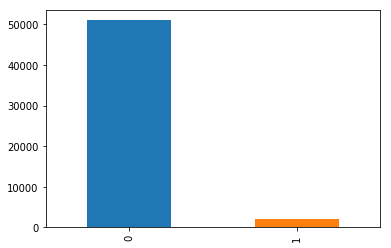

In [227]:
target_col = 'TARGET'
train[target_col].value_counts().plot(kind='bar')
plt.show()

In [228]:
train[target_col].value_counts()

0    50986
1     2067
Name: TARGET, dtype: int64

在训练集中，我们目标值0:1的比例约为24:1,说明样本分布不均衡

## 3 特征工程

### 3.1 删除值唯一的特征

In [229]:
no_features=list()
for col in train.columns:
    rate = train[col].value_counts(normalize=True, dropna=False).values[0]
    if rate==1.0:
        no_features.append(col)
        print(col,rate)

ind_var2_0 1.0
ind_var2 1.0
ind_var6 1.0
ind_var27_0 1.0
ind_var28_0 1.0
ind_var28 1.0
ind_var27 1.0
ind_var29 1.0
ind_var41 1.0
ind_var46_0 1.0
ind_var46 1.0
num_var6 1.0
num_var27_0 1.0
num_var28_0 1.0
num_var28 1.0
num_var27 1.0
num_var29 1.0
num_var41 1.0
num_var46_0 1.0
num_var46 1.0
saldo_var6 1.0
saldo_var28 1.0
saldo_var27 1.0
saldo_var29 1.0
saldo_var41 1.0
saldo_var46 1.0
imp_amort_var18_hace3 1.0
imp_amort_var34_hace3 1.0
imp_reemb_var13_hace3 1.0
imp_reemb_var33_hace3 1.0
imp_trasp_var17_out_hace3 1.0
imp_trasp_var33_out_hace3 1.0
num_var2_0_ult1 1.0
num_var2_ult1 1.0
num_reemb_var13_hace3 1.0
num_reemb_var33_hace3 1.0
num_trasp_var17_out_hace3 1.0
num_trasp_var33_out_hace3 1.0
saldo_var2_ult1 1.0
saldo_medio_var13_medio_hace3 1.0
saldo_medio_var29_ult1 1.0
saldo_medio_var29_ult3 1.0


### ~~3.2 删除值唯一比例大于0.99的特征~~

In [230]:
# for col in train.columns:
#     rate = train[col].value_counts(normalize=True, dropna=False).values[0]
#     if rate>0.99:
#         no_features.append(col)
#         print(col,rate)

一般来说（**对本次数据而言，如果将0认为缺失值的话**），对于高维数据和普通模型，通过删除缺失率比较高的特征，可以减少噪音特征对模型的干扰，但是我发现xgb（XGBoost）和lgb（LightGBM）树模型训练数据发现，直接删除缺失严重的特征会降低预测效果（0.821<0.826）。因为树模型自己在分裂节点的时候，会自动选择特征，确定特征的重要性，那些缺失严重的特征，重要性会等于0。

所以决定不删除大于0.99比例的值（发现这些值等于0），考虑原因有二：一是特征维度不高，而且是匿名特征；二是可以从基础特征重要性图片看出：模型自身具有选择特征的能力，可以更好的表现数据，

![](https://upload-images.jianshu.io/upload_images/1531909-4ff872e86f9e6145.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)


### 3.3 添加一些组合特征

In [231]:
# 选取一些缺失比较少（这里指含0比较少）
# x*y,x+y,x-y,x/y
train['var38+var15']=train['var38']+train['var15']
train['var38-var15']=train['var38']-train['var15']
train['var38*var15']=train['var38']*train['var15']
train['var38/var15']=train['var38']/(train['var15']+1)

train['saldo_var30+var15']=train['saldo_var30']+train['var15']
train['saldo_var30-var15']=train['saldo_var30']-train['var15']
train['saldo_var30*var15']=train['saldo_var30']*train['var15']
train['saldo_var30/var15']=train['saldo_var30']/(train['var15']+1)

train['saldo_medio_var5_ult3+saldo_var5']=train['saldo_medio_var5_ult3']+train['saldo_var5']
train['saldo_medio_var5_ult3-saldo_var5']=train['saldo_medio_var5_ult3']-train['saldo_var5']
train['saldo_medio_var5_ult3*saldo_var5']=train['saldo_medio_var5_ult3']*train['saldo_var5']
train['saldo_medio_var5_ult3/saldo_var5']=train['saldo_medio_var5_ult3']/(train['saldo_var5']+1)



test['var38+var15']=test['var38']+test['var15']
test['var38-var15']=test['var38']-test['var15']
test['var38*var15']=test['var38']*test['var15']
test['var38/var15']=test['var38']/(test['var15']+1)

test['saldo_var30+var15']=test['saldo_var30']+test['var15']
test['saldo_var30-var15']=test['saldo_var30']-test['var15']
test['saldo_var30*var15']=test['saldo_var30']*test['var15']
test['saldo_var30/var15']=test['saldo_var30']/(test['var15']+1)

test['saldo_medio_var5_ult3+saldo_var5']=test['saldo_medio_var5_ult3']+test['saldo_var5']
test['saldo_medio_var5_ult3-saldo_var5']=test['saldo_medio_var5_ult3']-test['saldo_var5']
test['saldo_medio_var5_ult3*saldo_var5']=test['saldo_medio_var5_ult3']*test['saldo_var5']
test['saldo_medio_var5_ult3/saldo_var5']=test['saldo_medio_var5_ult3']/(test['saldo_var5']+1)

添加这些特征后 **稍有提升 8.261->8.266**

### ~~3.4 添加多项式特征~~

In [232]:
# from sklearn.preprocessing import PolynomialFeatures
# def add_poly_features(data,column_names):
#     features=data[column_names]
#     rest_features=data.drop(column_names,axis=1)
#     poly_transformer=PolynomialFeatures(degree=2,interaction_only=False,include_bias=False)
#     poly_features=pd.DataFrame(poly_transformer.fit_transform(features),columns=poly_transformer.get_feature_names(column_names))

#     for col in poly_features.columns:
#         rest_features.insert(1,col,poly_features[col])
#     return rest_features

# # 这里选取一些缺失（为0）比较少，且列名差不多的特征，来生成多项式特征
# cols=['var38','var15','saldo_var30','saldo_var42','saldo_medio_var5_hace2','saldo_medio_var5_ult1','saldo_medio_var5_ult3','saldo_var5']
# train=add_poly_features(train,cols)
# test=add_poly_features(test,cols)

添加上述特征之后，auc有所下降

### 3.5 数值rank特征

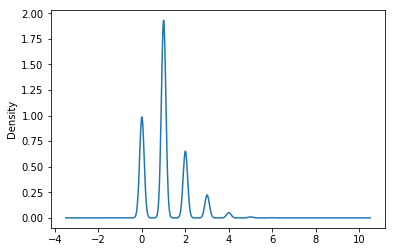

In [233]:
train['num_var4'].plot(kind='kde')
plt.show()

因为存在一些特征的取值大致范围在0-5，造成了数据密度分布不均匀，所以对齐进行rank排序，并且归一化

In [234]:
numerical_features=['num_var4','num_var45_ult3','num_meses_var5_ult3','num_var45_hace2','num_var22_ult3','num_var5']
for feat in numerical_features:
    train[feat] = train[feat].rank() / float(train.shape[0]) # 排序，并且进行归一化

for feat in numerical_features:
    test[feat] = test[feat].rank() / float(test.shape[0]) # 排序，并且进行归一化

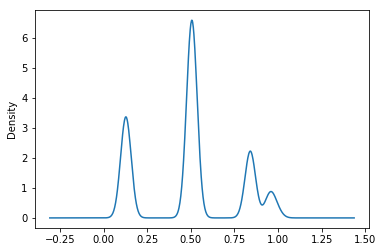

In [235]:
## 做过rank的num_var4
train['num_var4'].plot(kind='kde')
plt.show()

对于树模型来说，数值类型是不需要进行归一化处理的，因为它关心的不是变量的具体数值，而是变量的分布，这里进行rank，是保证对异常数据的鲁棒性，使其更加稳定，降低过拟合风险

In [236]:
no_features.append('ID')
no_features.append('TARGET')
features = [feat for feat in train.columns.values if feat not in no_features]

In [237]:
X=train[features].values
y=train['TARGET'].values

In [238]:
test_data=test[features].values

## 4 训练模型

### 4.1 LightGBM

In [239]:
# 采取分层采样
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.metrics import roc_auc_score
import time


print("start：********************************")
start = time.time()

# 分层采样，确保训练集，测试集中各类别样本的比例与原始数据集中相同
N = 5 
skf = StratifiedKFold(n_splits=N,shuffle=True,random_state=2019)


lgb_auc_cv = []
lgb_pred_cv = []

for k,(train_in,test_in) in enumerate(skf.split(X,y)):
    X_train,X_test,y_train,y_test = X[train_in],X[test_in],\
                                    y[train_in],y[test_in]
    
    # 数据结构
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

    # 设置参数
    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': {'auc'},
        'max_depth': -1,
        'min_child_weight': 6,
        'num_leaves': 16,
        'learning_rate': 0.02,# 0.05
        'feature_fraction': 0.7,
        'bagging_fraction': 0.7,
        'bagging_freq': 5,
        'lambda_l1':0.25,
        'lambda_l2':0.5,
        #'scale_pos_weight':10.0/1.0, #14309.0 / 691.0, #不设置
    }

    print('................Start training..........................')
    # train
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=2000,
                    valid_sets=lgb_eval,
                    early_stopping_rounds=100,
                    verbose_eval=100)

    print('................Start predict .........................')
    # 预测
    y_pred = gbm.predict(X_test,num_iteration=gbm.best_iteration)
    # 评估
    tmp_auc = roc_auc_score(y_test,y_pred)
    lgb_auc_cv.append(tmp_auc)
    print("valid auc:",tmp_auc)
    # test
    pred = gbm.predict(test_data, num_iteration = gbm.best_iteration)
    lgb_pred_cv.append(pred) 
    
# K交叉验证的平均分数 
print('the lgb cv information:')
print(lgb_auc_cv)
print('lgb cv mean score',np.mean(lgb_auc_cv))

end = time.time()
print("......................run with time: ",(end - start) / 60.0 )
print("over:*********************************")

start：********************************
................Start training..........................
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.848462
[200]	valid_0's auc: 0.850598
[300]	valid_0's auc: 0.851099
[400]	valid_0's auc: 0.850216
Early stopping, best iteration is:
[330]	valid_0's auc: 0.85153
................Start predict .........................
valid auc: 0.8515302801629192
................Start training..........................
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.843837
[200]	valid_0's auc: 0.843948
Early stopping, best iteration is:
[130]	valid_0's auc: 0.845166
................Start predict .........................
valid auc: 0.8451664053887213
................Start training..........................
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.837024
[200]	valid_0's auc: 0.838114
Early stopping, best iteration is:
[197]	valid_0's auc: 0.83

### 4.2 XGBoost

In [240]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
print("start：********************************")
start = time.time()

xgb_auc_list = []
xgb_pred_list = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2018)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #参数设置
    params = {'booster': 'gbtree',
              'objective':'binary:logistic',
              'eta': 0.02,
              'max_depth':4,
              'min_child_weight': 6,  
              'colsample_bytree': 0.7,
              'subsample': 0.7,
              #'gamma':0,
              #'lambda':1,
              #'alpha ':0，
              'silent':1
              }
    params['eval_metric'] = ['auc'] 
    # 数据结构
    dtrain = xgb.DMatrix(X_train, label = y_train)
    dvali = xgb.DMatrix(X_test,label = y_test)
    evallist  = [(dtrain,'train'),(dvali,'valid')]  # 'valid-auc' will be used for early stopping
    # 模型train
    model = xgb.train(params, dtrain,
                      num_boost_round=2000, 
                      evals = evallist,
                      early_stopping_rounds = 100,
                      verbose_eval=100)
    # 预测验证
    pred = model.predict(dvali, ntree_limit = model.best_ntree_limit)
    # 评估
    auc = roc_auc_score(y_test,pred)
    print('...........................auc value:',auc)
    xgb_auc_list.append(auc)
    # 预测
    dtest = xgb.DMatrix(test_data)
    pre = model.predict(dtest,ntree_limit = model.best_ntree_limit)
    xgb_pred_list.append(pre)

print('.....................xgb validate result  mean :',np.mean(xgb_auc_list))

end = time.time()
print("......................run with time: ",(end - start) / 60.0)

print("over:*********************************")


start：********************************
[0]	train-auc:0.812267	valid-auc:0.807765
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[100]	train-auc:0.853879	valid-auc:0.83731
[200]	train-auc:0.861873	valid-auc:0.842395
[300]	train-auc:0.868995	valid-auc:0.845106
[400]	train-auc:0.87462	valid-auc:0.846492
[500]	train-auc:0.879329	valid-auc:0.847479
[600]	train-auc:0.884173	valid-auc:0.847544
[700]	train-auc:0.888511	valid-auc:0.847766
Stopping. Best iteration:
[631]	train-auc:0.885469	valid-auc:0.848013

...........................auc value: 0.8480129664526435
[0]	train-auc:0.798549	valid-auc:0.799647
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[100]	train-auc:0.853806	valid-auc:0.835825
[200]	train-auc:0.86277	valid-auc:0.841273
[300]	train-auc:0.870793	valid-auc:0.843898
[400]	train-auc:0.876675

## 5 预测结果

In [241]:
y_test=test['TARGET']

### 5.1 模型1 lgb

In [251]:
# 转为array
res =  np.array(lgb_pred_cv)
# 最后结果平均，mean
lgb_r = res.mean(axis = 0)
# 最终在测试集上的预测结果
print("lgb auc on test data:",roc_auc_score(y_test,lgb_r))

lgb auc on test data: 0.8267077465111515


### 5.2 模型2 xgb

In [252]:
# 转为array
res =  np.array(xgb_pred_list)
# 最后结果平均，mean
xgb_r = res.mean(axis = 0)
# 最终在测试集上的预测结果
print("xgb auc on test data:",roc_auc_score(y_test,xgb_r))

xgb auc on test data: 0.8268939577060556


### 5.3 加权求和

In [253]:
r=0.4*lgb_r+0.6*xgb_r
print("xgb auc on test data:",roc_auc_score(y_test,r))

xgb auc on test data: 0.8269702369907153


## 6 特征重要性

In [ ]:
train_all = lgb.Dataset(train[features], train['TARGET'])
# 设置参数
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'auc'},
    'max_depth': 4,
    'min_child_weight': 6,
    'num_leaves': 16,
    'learning_rate': 0.02,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    #'lambda_l1':0.25,
    #'lambda_l2':0.5,
    #'scale_pos_weight':1,
}
model = lgb.train(params,
                train_all,
                num_boost_round=450,
                valid_sets=train_all,
                early_stopping_rounds=100,
                verbose_eval=100)
# 显示top30的特征
lgb.plot_importance(model,max_num_features = 30,figsize=(20,10))
plt.show()